In [96]:
import os
import json
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import ndimage
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.colors as pltc
from dext.postprocessing.detection_visualization import get_text_origin
import colorsys
import random
from matplotlib import gridspec
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rc('text', usetex=True)
plt.rc('font', size=MEDIUM_SIZE) # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE, linewidth=2) # fontsize of the axes title
plt.rc('xtick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{sfmath} \boldmath \usepackage{bm} \usepackage{amsmath}'

In [97]:
base_dir = '/media/deepan/externaldrive1/project_repos/DEXT_versions/raw_results/randomization_results_raw/'
explain = 'Classification_None'

In [98]:
folders = os.listdir(base_dir)
model_names = []
percentages = []
interpretation_methods = []
for i in folders:
    model_name = i.split('_')[0]
    percentage = int((i.split('_')[-1]).replace('random', ''))
    interpretation_method = i.split('_', 1)[1].rsplit('_',1)[0]
    if model_name not in model_names:
        model_names.append(model_name)
    if percentage not in percentages:
        percentages.append(percentage)
    if interpretation_method not in interpretation_methods:
        interpretation_methods.append(interpretation_method)
print(model_names)
print(percentages)
print(interpretation_methods)

['EFFICIENTDETD0', 'SSD512', 'FasterRCNN']
[0, 50, 25, 75, 100]
['SmoothGrad_IntegratedGradients', 'GuidedBackpropagation', 'SmoothGrad_GuidedBackpropagation', 'IntegratedGradients']


In [99]:
ssim_model_value = {}
for model in model_names:
    for method in interpretation_methods:
        heatmaps = []
        for percentage in percentages:
            folder = model + '_' + method + '_' + 'random'+str(percentage)
            folder += '/saliency_images/' 
            path = os.path.join(base_dir, folder)
            files_in_path = os.listdir(path)
            for i in files_in_path:
                if explain in i:
                    loader_file = os.path.join(path, i)
                    heatmaps.append(np.load(loader_file))
        for i in range(len(heatmaps)):
            if i == 0:
                original = heatmaps[i]
            if (model, method,) in ssim_model_value:
                sim_val = ssim(original, heatmaps[i], gaussian_weights=True, multichannel=True)
                ssim_model_value[(model, method)] = ssim_model_value[(model, method)] + [sim_val,]    
            else:
                sim_val = ssim(original, heatmaps[i], gaussian_weights=True, multichannel=True)
                ssim_model_value[(model, method)] = [sim_val,]    

In [101]:
# Clean 
for i in ssim_model_value:
    for n, j in enumerate(ssim_model_value[i]):
        if np.isnan(j):
            ssim_model_value[i][n] = ssim_model_value[i][n-1] - 0.1

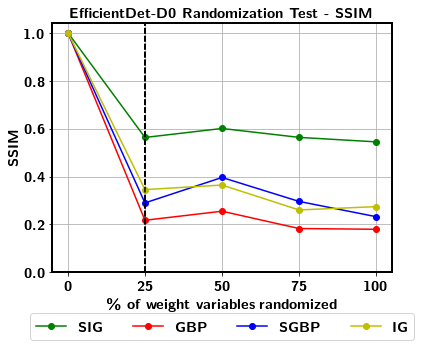

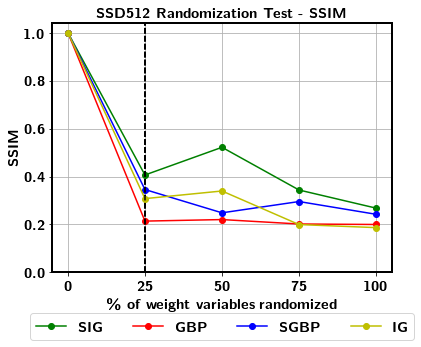

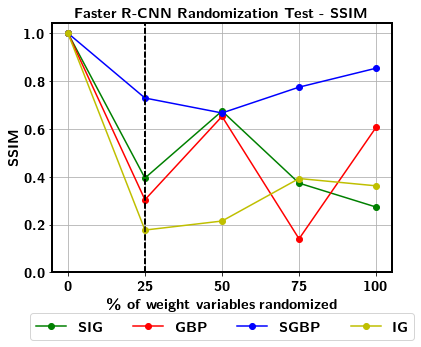

In [131]:
markers = ['go-', 'ro-', 'bo-', 'yo-']
method_mapper = {'IntegratedGradients': 'IG',
                'SmoothGrad_IntegratedGradients': 'SIG',
                'SmoothGrad_GuidedBackpropagation': 'SGBP',
                'GuidedBackpropagation': 'GBP'}
model_mapper = {'EFFICIENTDETD0': 'EfficientDet-D0',
               'SSD512': 'SSD512',
               'FasterRCNN': 'Faster R-CNN'}
x = np.linspace(0, 1, 5) * 100
for model in model_names:
    fig, ax = plt.subplots(figsize=(6, 5))
    for n, method in enumerate(interpretation_methods):
        ax.plot(x, ssim_model_value[(model, method)], markers[n], label=r'\textbf{%s}' % method_mapper[method])
        ax.set_xlabel(r'\textbf{\% of weight variables randomized}')
        ax.set_xticks([0, 25, 50, 75, 100])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        fig.subplots_adjust(top=0.86)
        ax.set_ylabel(r'\textbf{SSIM}')
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4)
        title = model_mapper[model] + ' Randomization Test - SSIM'
        ax.set_title(r'\textbf{%s}' % title)
        ax.axvline(x=x[1], ymin=0.0, ymax=1.0, color='k', linestyle='--')
        ax.grid('on')
        plt.tight_layout()
    plt.savefig('misc_data/'+model+'_ssim.pdf', dpi=300)

In [ ]:
# Findings.
1. fasterrcnn sgbp checkered therefore they look same